In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score




In [3]:
df = pd.read_excel('./data/archivo.xlsx')
df.head()

,sku,storeReference,totalSales,date,warehouseId,macroCategory,category,stock,totalUSD,salesDuringCommercialActivities,locationId
0,5000281005034,Whisky Old Parr 12 Años - Old Parr - Botella 5...,2,2022-01-06,50,Licores y cigarrillos,Whiskys,164,12.568690,2,7
1,7500435107723,12 Prestobarba UG 3 + 12 Prestobarba UG 2 ultr...,1,2022-01-06,50,Cuidado personal,Afeitado y depilacion,85,8.880544,1,7
2,7500435160179,Detergente en polvo - Ariel Revitacolor - Uni...,4,2022-01-06,50,Cuidado del hogar,Cuidado de la ropa,1996,0.567125,4,7
3,7506174514396,Alimento Para Perro adulto - Pedigree - Bolsa...,4,2022-01-06,50,Mascotas,Alimento para perros,35,2.230369,4,7
4,7701021114464,Pañal etapa 5 - Winny Ultra Sec - Paquete 30 uds.,4,2022-01-06,50,Bebés y Niños,Pañales,109,5.837699,4,7


In [5]:
len(df.sku.unique())

2029

#### Datasets Problems:
1. The problem mention Data Product Types, but the dataset aint have a column or a flag that indicates de product Type, so, include the `leadtime` in the analysis is useless

#### EDA

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by = ['date'], inplace = True)
df['sku'] = df['sku'].astype(str)
# ----------------------
# FEATURE ENGINEERING
# ----------------------
df['unit_price_USD'] = df['totalUSD'] / df['totalSales']
df['unit_price_USD'] = df['unit_price_USD'].apply(lambda x: round(x,3))

# Changing date to datetime and Creating New Columns
df['week_of_year'] = df['date'].apply(lambda x: x.strftime('%W').lower()).astype(int)
df['day_of_month'] = df['date'].apply(lambda x: x.strftime('%d')).astype(int)
df['fortnite'] = df['day_of_month'].apply(lambda x: 1 if x <=15 else 2)
df['month'] = df['date'].apply(lambda x: x.strftime('%B').lower())
df['month_number'] = df['date'].apply(lambda x: x.strftime('%m').lower())
df['day_name'] = df['date'].apply(lambda x: x.strftime('%A').lower())
df['day_of_year'] = df['date'].apply(lambda x: x.strftime('%-j').lower()).astype(int)
df.columns

Index(['sku', 'storeReference', 'totalSales', 'date', 'warehouseId',
       'macroCategory', 'category', 'stock', 'totalUSD',
       'salesDuringCommercialActivities', 'locationId', 'unit_price_USD',
       'week_of_year', 'day_of_month', 'fortnite', 'month', 'month_number',
       'day_name', 'day_of_year'],
      dtype='object')

In [7]:
df.category.value_counts(normalize=True)

Gaseosas y maltas                 0.087528
Dulces, chupetas, gomitas         0.069967
Aguas, sodas y tónicas            0.067893
Jugos, néctares y tés líquidos    0.062293
Cuidado de la ropa                0.057453
                                    ...   
Formulas materno infantil         0.000207
Pañales de adulto                 0.000138
Lácteos culinarios                0.000069
Electrodomésticos                 0.000069
Panes y tostadas                  0.000069
Name: category, Length: 75, dtype: float64

In [8]:
df.macroCategory.value_counts(normalize=True)

Bebidas no alcohólicas          0.258711
Dulces y pasabocas (Botanas)    0.210592
Cuidado del hogar               0.115113
Licores y cigarrillos           0.107093
Cuidado personal                0.102738
Canasta básica                  0.071073
Despensa                        0.036504
Mascotas                        0.032633
Cuidado de la salud             0.024336
Bebés y Niños                   0.020741
Lácteos y refrigerados          0.020119
Cuidado de la ropa y calzado    0.000277
Hogar y electrodomésticos       0.000069
Name: macroCategory, dtype: float64

In [9]:
len(df.macroCategory.unique())

13

In [5]:
def line_plot_hue(df:pd.DataFrame, x_feature:str, y_feature:str, hue: str):
    red_blue = ['#EF4836','#19B5FE']

    fig,ax = plt.subplots(figsize=(20, 7))


    plt.title(f'{x_feature} vs {y_feature} \n Line Plot', fontsize=14)
    data = df.groupby([f'{x_feature}',f'{hue}'])[f'{y_feature}'].sum().reset_index()
    g = sns.lineplot(data=data, x=f'{x_feature}', y=f'{y_feature}', style=f'{hue}', hue = f'{hue}', markers=True, dashes=False,ci=None, palette=red_blue )
    g.axhline(data[y_feature].mean(), color = 'black', lw = 1, ls='--')  
    plt.legend(loc = 'upper right', fontsize=14)
    plt.xlabel(f'{x_feature}', fontsize=14)
    plt.ylabel(f'{y_feature}', fontsize=14)
    # plt.ylim(df[y_feature].min(), df[y_feature].max())
    plt.show();


,fortnite,month_number,totalSales
0,1,01,253722
1,1,02,409980
2,2,01,485856
3,2,02,457827


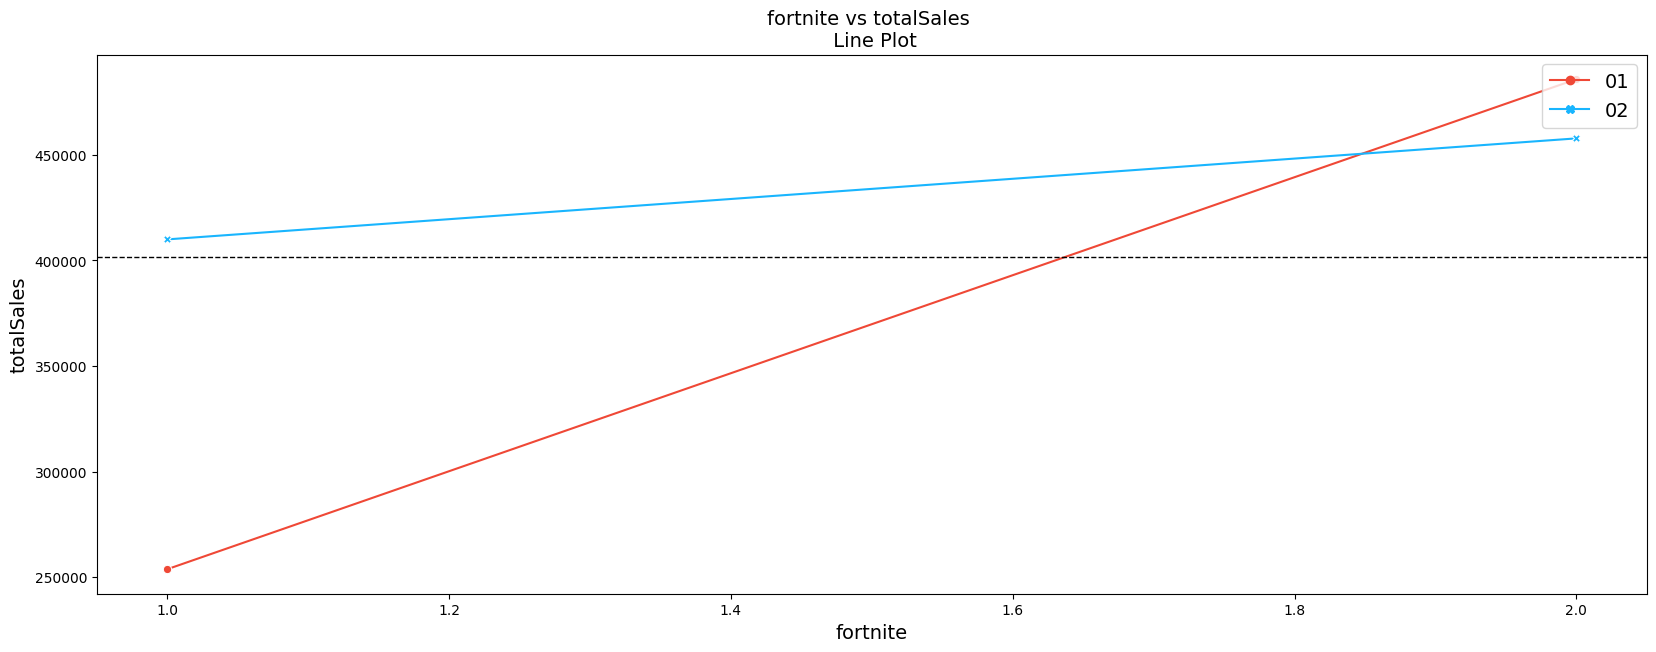

In [109]:
g = df.groupby(['fortnite','month_number'])['totalSales'].sum().reset_index()
# sns.lineplot(data=g, x=f'fortnite', y=f'totalSales', markers=True, dashes=False,ci=None )
display(g)
line_plot_hue( df = g, x_feature = 'fortnite', y_feature = 'totalSales', hue = 'month_number')

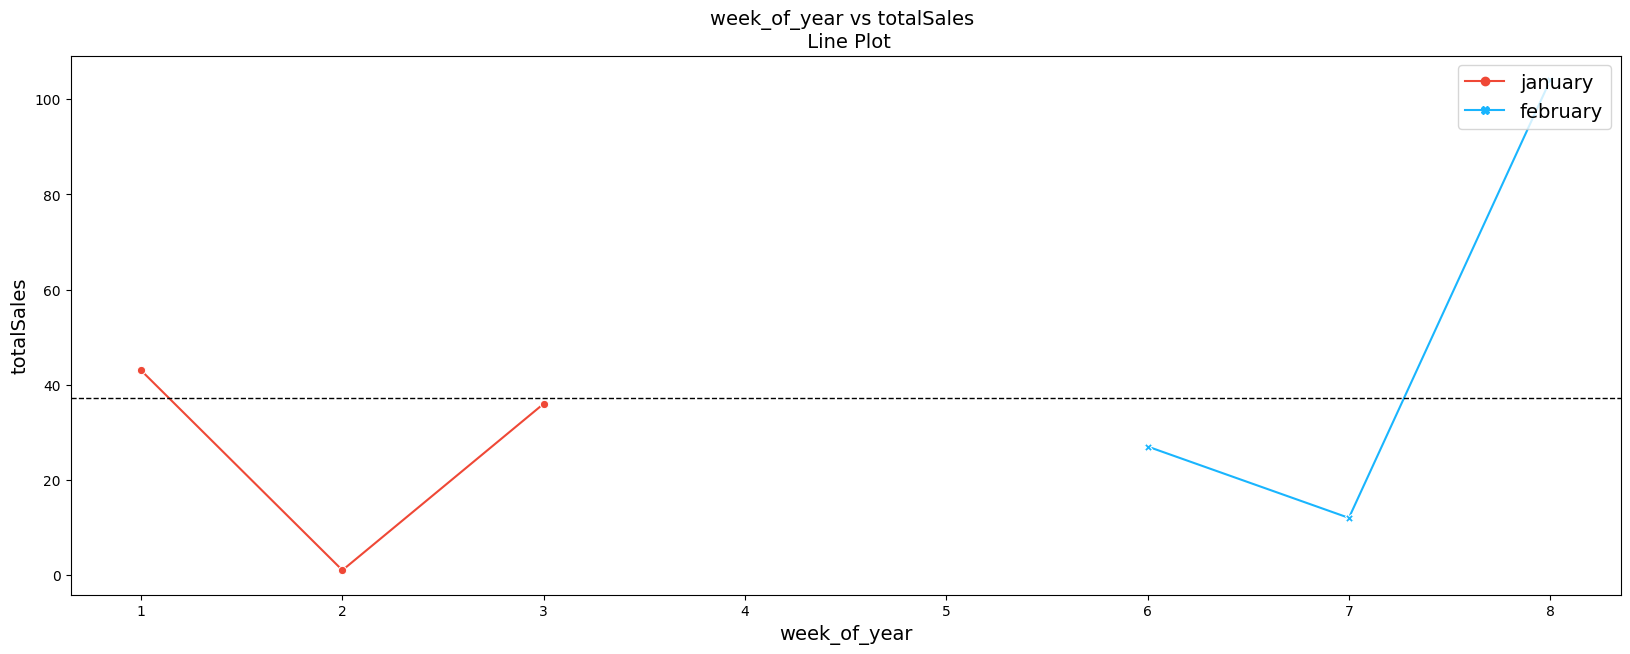

In [20]:
x = df[df['sku'] == 5000281005034]
line_plot_hue( df = x, x_feature = 'week_of_year', y_feature = 'totalSales', hue = 'month')

In [3]:
df.columns

Index(['sku', 'storeReference', 'totalSales', 'date', 'warehouseId',
       'macroCategory', 'category', 'stock', 'totalUSD',
       'salesDuringCommercialActivities', 'locationId'],
      dtype='object')

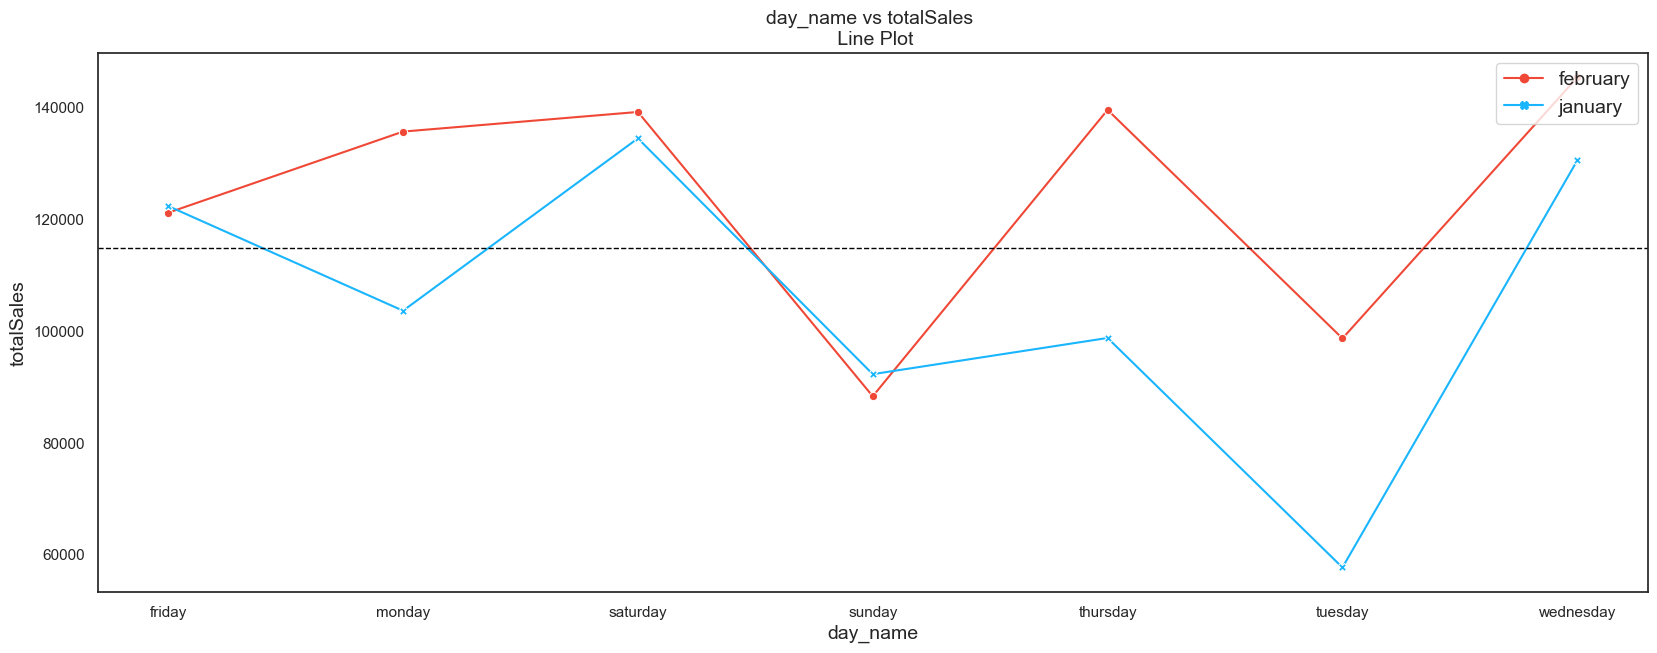

In [144]:
line_plot_hue( df = df, x_feature = 'day_name', y_feature = 'totalSales', hue = 'month')

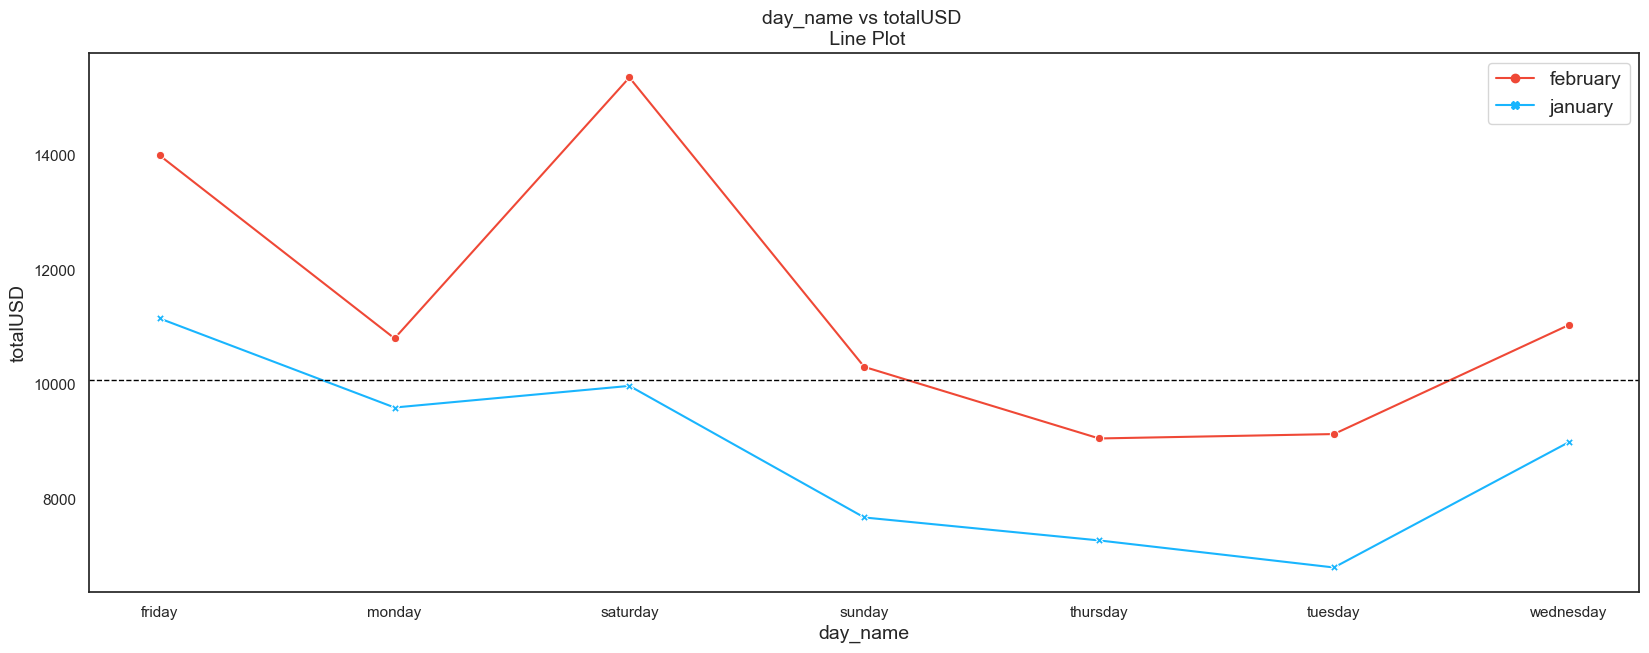

In [149]:
line_plot_hue( df = df, x_feature = 'day_name', y_feature = 'totalUSD', hue = 'month')

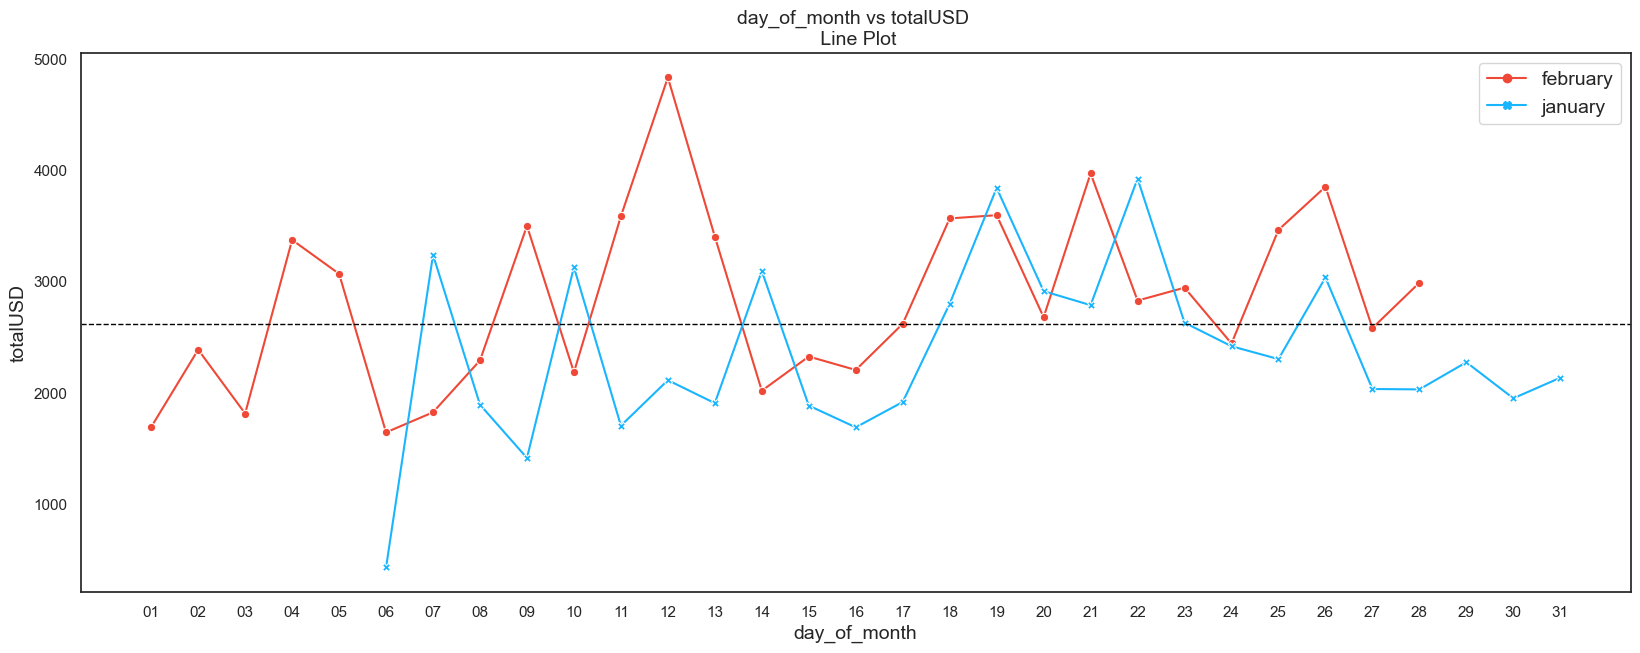

In [150]:
line_plot_hue( df = df, x_feature = 'day_of_month', y_feature = 'totalUSD', hue = 'month')

In [105]:
def plt_hist_with_hue(target_one:pd.DataFrame, target_cero: pd.DataFrame, feature:str, bins = 30, normalize = True)->plt:
    """Plot 2 histograms in 1 plot, with alpha 

    Args:
        target_one (pd.DataFrame): dataframe with target value = 1
        target_cero (pd.DataFrame): dataframe with target value = 0
        feature (str): feature name 

    Returns:
        plt: matplot lib chart
    """
    red_blue = ['#EF4836','#19B5FE']
    palette = sns.color_palette(red_blue)
    sns.set_palette(palette)
    sns.set_style("white")

    fig,ax = plt.subplots(figsize=(20, 7))

    #   {feature}
    plt.title(f'{feature}\nDistribution', fontsize=16)
    target_one[f'{feature}'].hist( alpha=0.7, bins=bins, label = 'January',density=normalize)
    target_cero[f'{feature}'].hist( alpha=0.7, bins=bins, label = 'February',density=normalize)
    plt.legend(loc = 'upper right', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    # fig.tight_layout()
    plt.show()

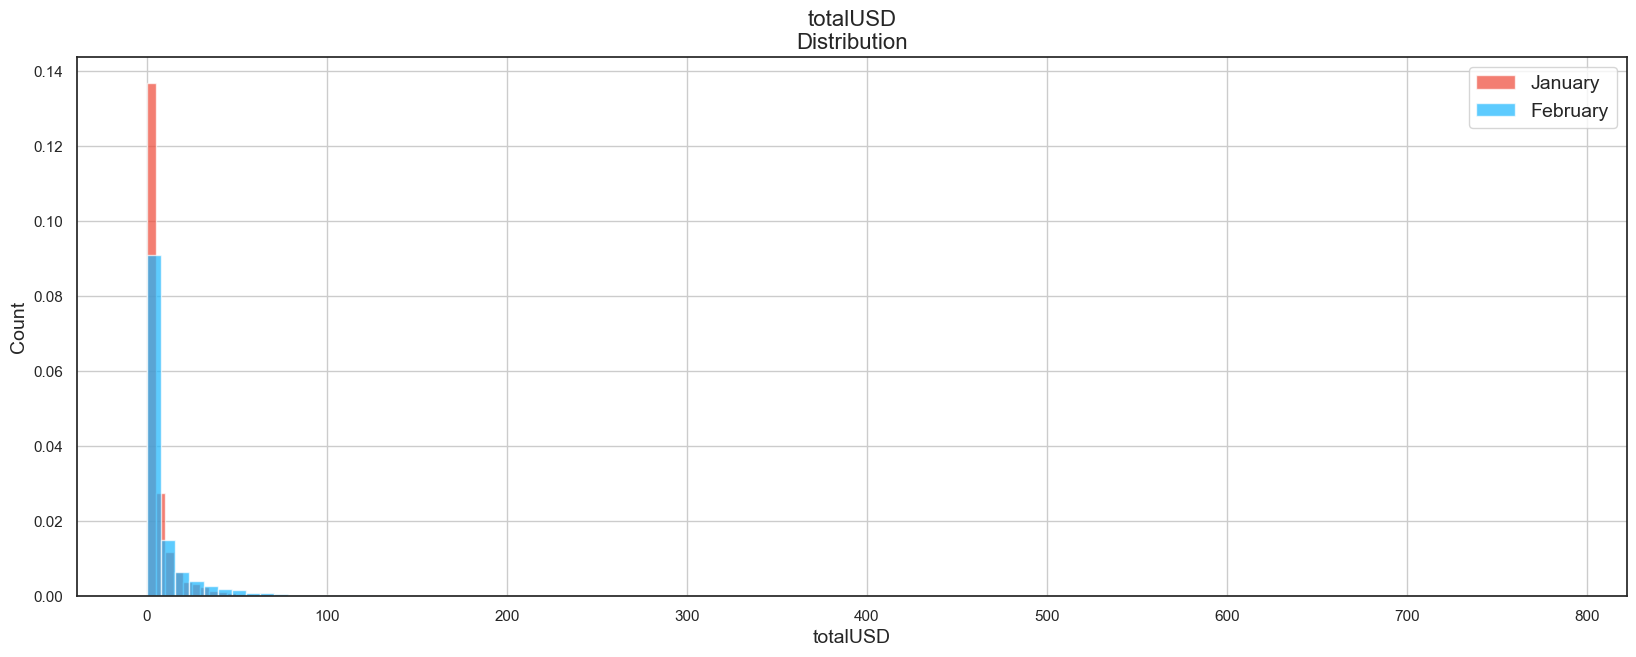

In [106]:
target_one = df[df['month'] == 'january']
target_cero = df[df['month'] == 'february']
plt_hist_with_hue(target_one,target_cero,feature = 'totalUSD', bins = 100)

In [146]:
fetaures_to_use = ['sku','totalSales','unit_price_USD','category','macroCategory','week_of_year','day_of_month','day_of_year','stock','month']
df = df[fetaures_to_use]

In [147]:
x = df[df['sku'] == 5000281005034]
# line_plot_hue( df = x, x_feature = 'week_of_year', y_feature = 'totalSales', hue = 'month')
data = x.groupby([f'week_of_year',f'month'])[f'totalSales'].sum().reset_index()

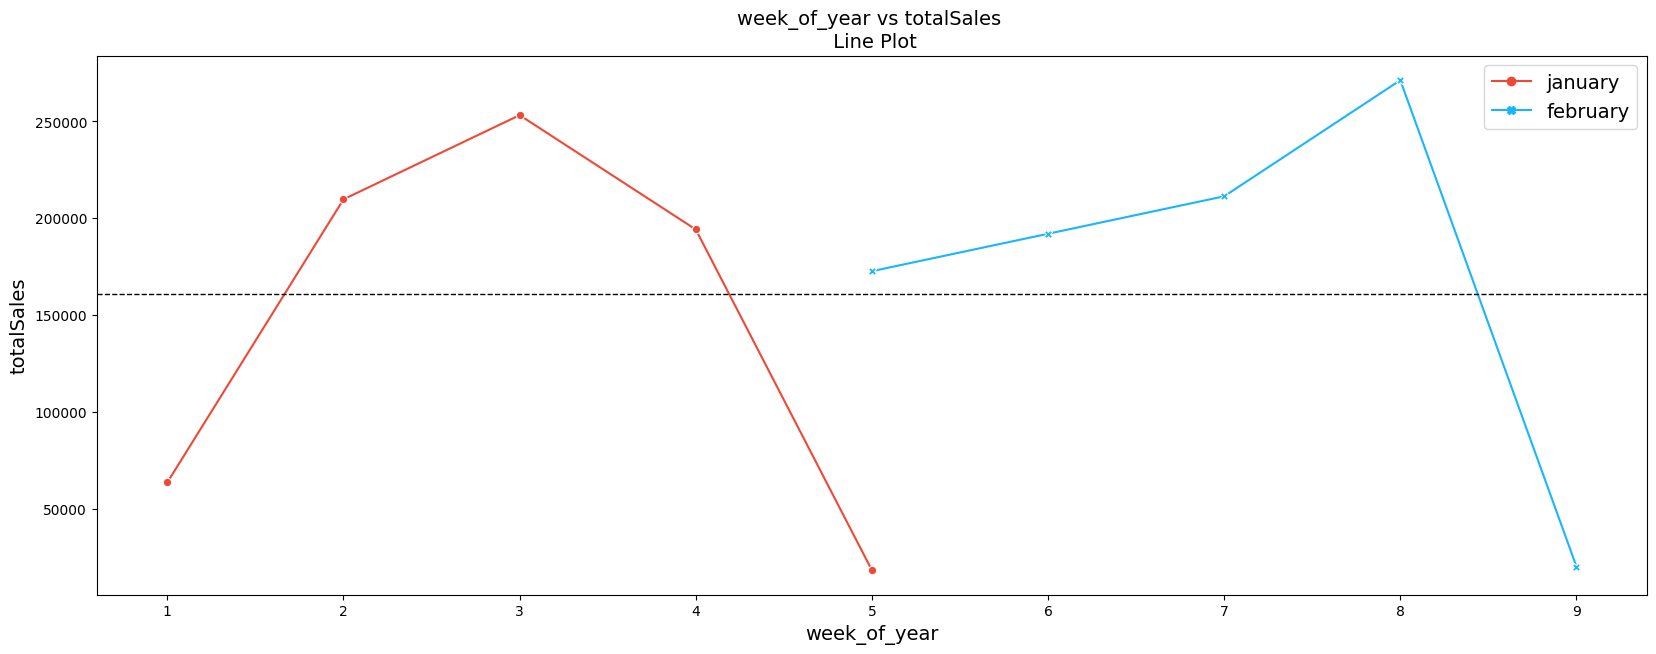

In [93]:
line_plot_hue( df = df, x_feature = 'week_of_year', y_feature = 'totalSales', hue = 'month')


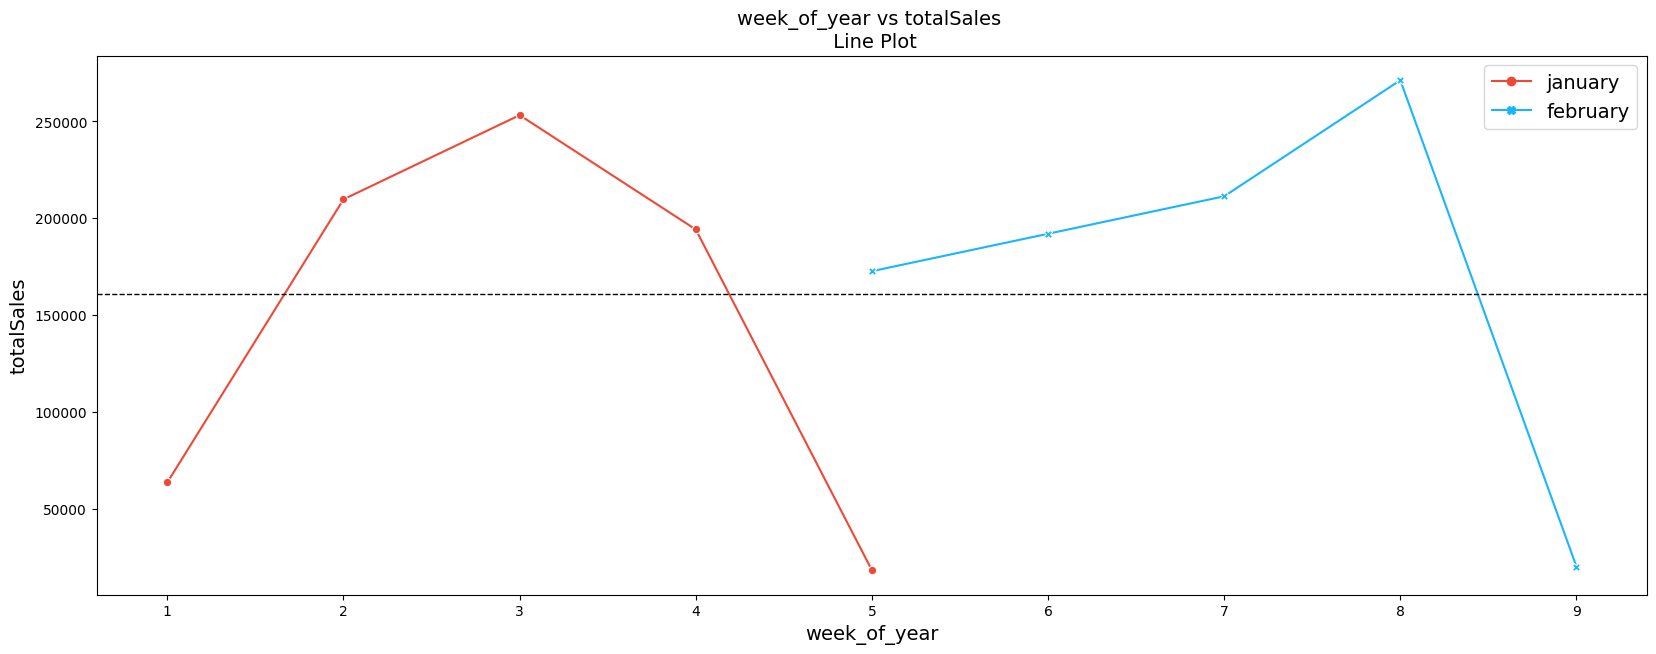

In [162]:
g = df.groupby(['week_of_year','month'])['totalSales'].sum().reset_index()
line_plot_hue( df = g, x_feature = 'week_of_year', y_feature = 'totalSales', hue = 'month')

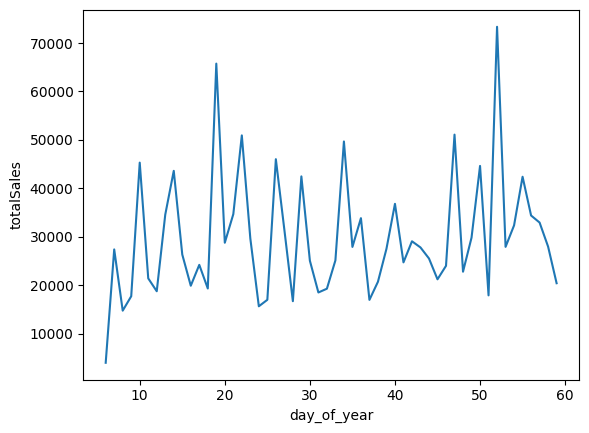

In [171]:
g = df.groupby(['day_of_year'])['totalSales'].sum().reset_index()
g = sns.lineplot(data=g, x=f'day_of_year', y=f'totalSales',  markers=True, dashes=False,ci=None)

In [5]:
x = df.groupby(['day_of_year','unit_price_USD','category','macroCategory','week_of_year','day_of_month','month_number','stock','sku'])['totalSales'].sum().reset_index()
x
# fetaures_to_use = ['totalSales','unit_price_USD','category','macroCategory','week_of_year','day_of_month','day_of_year','month_number','stock']
# x = x[fetaures_to_use]

,day_of_year,unit_price_USD,category,macroCategory,week_of_year,day_of_month,month_number,stock,sku,totalSales
0,6,0.002,Arroz,Canasta básica,1,6,01,91206,7707295760000,1024
1,6,0.005,Gaseosas y maltas,Bebidas no alcohólicas,1,6,01,1635,7702535011089,168
2,6,0.006,Salsas,Despensa,1,6,01,1770,7702439073985,24
3,6,0.010,"Jugos, néctares y tés líquidos",Bebidas no alcohólicas,1,6,01,67,7702535022481,48
4,6,0.013,Gaseosas y maltas,Bebidas no alcohólicas,1,6,01,128,77082381,12
...,...,...,...,...,...,...,...,...,...,...
14459,59,13.632,Whiskys,Licores y cigarrillos,9,28,02,36,80432402931,2
14460,59,13.832,Whiskys,Licores y cigarrillos,9,28,02,128,50196388,6
14461,59,14.201,"Caldos, sopas y cremas",Despensa,9,28,02,90,7702354949563,1
14462,59,16.867,Whiskys,Licores y cigarrillos,9,28,02,35,80432400432,1


In [10]:
X = x.drop(columns = {'totalSales'}, axis = 1)
y = x['totalSales']
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5, random_state = 0)

categorical_columns = X_train.select_dtypes(include=['object']).columns.to_list()
numerical_columns = X_train.select_dtypes(exclude=['object']).columns.to_list()

column_transformers = ColumnTransformer([
('MinMaxScaler', MinMaxScaler(),numerical_columns),
('One Hot Encoding', OneHotEncoder(sparse=False, handle_unknown= 'ignore'),categorical_columns)
])


model = RandomForestRegressor()
model_name = model.__class__.__name__       


# Build the pipeline
pipe = Pipeline([
                    ('Column Transformer',column_transformers),
                    ('Model', model)
                ])


In [11]:
pipe.fit(X_train, y_train);
y_predict = pipe.predict(X_test)
print(f'mae = {mean_absolute_error(y_test, y_predict)}')
print(f'r2 = {r2_score(y_test, y_predict)}')

mae = 68.73522123893805
r2 = 0.6708919155912005


In [12]:
import pickle
import os

model_save_path = './model'
output_file = os.path.join(model_save_path, 'model.pkl')
pickle.dump(pipe,open(output_file,'wb'))


In [13]:
pipe

Pipeline(steps=[('Column Transformer',
                 ColumnTransformer(transformers=[('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['day_of_year',
                                                   'unit_price_USD',
                                                   'week_of_year',
                                                   'day_of_month', 'stock']),
                                                 ('One Hot Encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['category', 'macroCategory',
                                                   'month_number', 'sku'])])),
                ('Model', RandomForestRegressor())])

In [14]:
y = pd.DataFrame(y_test)
y['y_predict'] = [ int(i) for i in y_predict]
y['error'] = y['y_predict'] - y['totalSales']
try:
    y['day_of_year'] = X_test
except:
    y = y.join(X_test)
# del y['error']
y

,totalSales,y_predict,error,day_of_year,unit_price_USD,category,macroCategory,week_of_year,day_of_month,month_number,stock,sku
12990,3,4,1,54,0.797,Proteccion femenina,Cuidado personal,8,23,02,322,7702027436932
2873,1,3,2,15,0.617,Cuidado de la ropa,Cuidado del hogar,2,15,01,326,7707291394957
13776,2,11,9,57,0.154,Cuidado de la piel,Cuidado personal,8,26,02,110,7701018075464
4265,24,30,6,21,0.022,"Jugos, néctares y tés líquidos",Bebidas no alcohólicas,3,21,01,67,7702535014233
12928,4,9,5,54,0.199,Toallitas húmedas,Bebés y Niños,8,23,02,905,7896018700628
...,...,...,...,...,...,...,...,...,...,...,...,...
6283,3,3,0,27,8.576,"Ron, brandy y coñac",Licores y cigarrillos,4,27,01,37,7702168268508
5525,12,22,10,25,0.055,Enlatados,Despensa,4,25,01,29,7702014306606
678,6,5,-1,8,0.627,"Dulces, chupetas, gomitas",Dulces y pasabocas (Botanas),1,8,01,0,7702011130747
8918,34,25,-9,40,0.066,Galletas,Dulces y pasabocas (Botanas),6,9,02,183,7702025185344


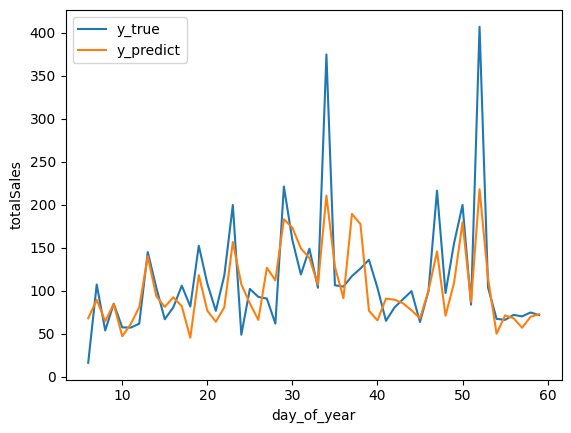

In [15]:
red_blue = ['#EF4836','#19B5FE']
sns.lineplot(data = y, x = 'day_of_year', y = 'totalSales', markers=True, dashes=False,ci=None, label = 'y_true')
sns.lineplot(data = y, x = 'day_of_year', y = 'y_predict',markers=True, dashes=False,ci=None, label = 'y_predict')
plt.show();

<AxesSubplot: >

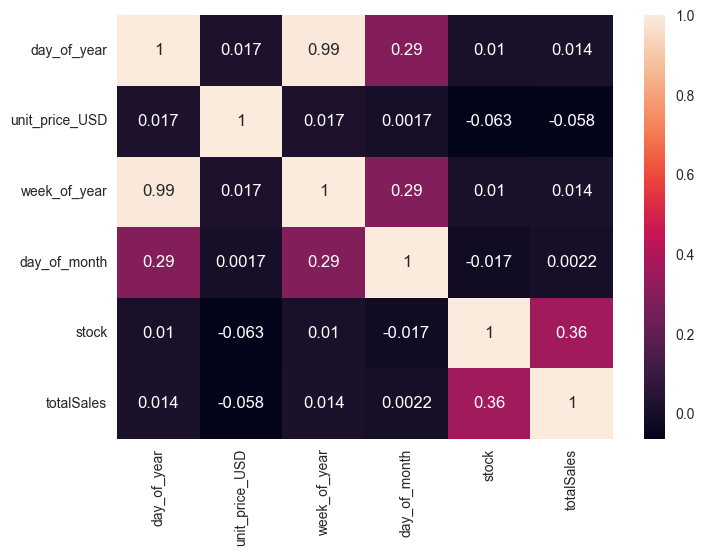

In [256]:
sns.heatmap(x.corr(), annot=True)

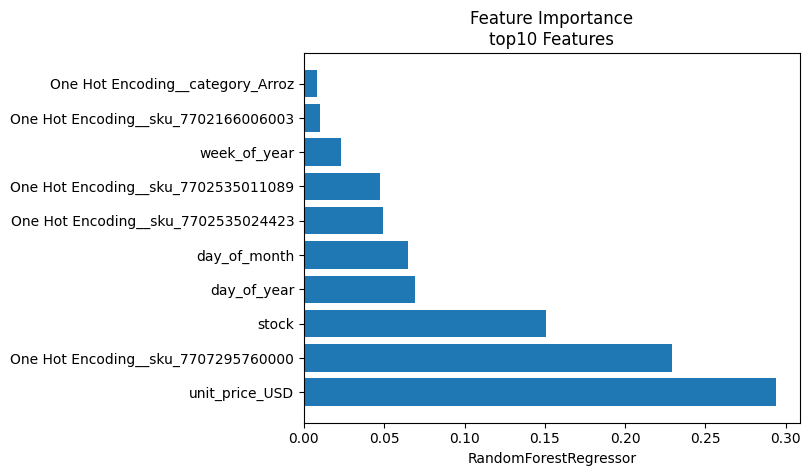

In [17]:
def plot_feature_importance_from_pipeline(pipe: Pipeline, top_n_features:int, model_name = model_name):
    colums_after_pipelines = pipe[:-1].get_feature_names_out()
    feature_importances_list = pipe.named_steps['Model'].feature_importances_
    zipped = zip(list(feature_importances_list), list(colums_after_pipelines))
    feature_importances_df = pd.DataFrame(zipped, columns = ['importances','feature'])
    feature_importances_df.sort_values(by = 'importances', inplace = True, ascending=False)
    feature_importances_df = feature_importances_df.head(top_n_features)
    feature_importances_df['feature'] = feature_importances_df['feature'].apply(lambda x: x.replace('MinMaxScaler__',''))

    plt.title('Feature Importance\ntop10 Features')
    plt.barh( feature_importances_df['feature'],feature_importances_df['importances'], )
    plt.xlabel(f"{model_name}")


    return feature_importances_df

feature_importances_df = plot_feature_importance_from_pipeline(pipe,top_n_features=10)

In [239]:
x

,day_of_year,unit_price_USD,category,macroCategory,week_of_year,day_of_month,month_number,stock,totalSales
0,6,0.002,Arroz,Canasta básica,1,6,01,91206,1024
1,6,0.005,Gaseosas y maltas,Bebidas no alcohólicas,1,6,01,1635,168
2,6,0.006,Salsas,Despensa,1,6,01,1770,24
3,6,0.010,"Jugos, néctares y tés líquidos",Bebidas no alcohólicas,1,6,01,67,48
4,6,0.013,Gaseosas y maltas,Bebidas no alcohólicas,1,6,01,128,12
...,...,...,...,...,...,...,...,...,...
14384,59,13.632,Whiskys,Licores y cigarrillos,8,28,02,36,2
14385,59,13.832,Whiskys,Licores y cigarrillos,8,28,02,128,6
14386,59,14.201,"Caldos, sopas y cremas",Despensa,8,28,02,90,1
14387,59,16.867,Whiskys,Licores y cigarrillos,8,28,02,35,1
